In [1]:
%pip install --quiet --upgrade flax transformers
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.975
%env TOKENIZERS_PARALLELISM="false"

import random
import itertools

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import requests
import optax
import tqdm

from typing import Generator
from dataclasses import dataclass
from pprint import pprint

from flax import nnx
from transformers import AutoTokenizer, TextStreamer

default_dtype = (
    jnp.bfloat16
    # jnp.float32
)

@jax.vmap
def binary_operator_diag(q_i, q_j):
    (A_i, b_i), (A_j, b_j) = q_i, q_j
    return A_j * A_i, A_j * b_i + b_j


def parallel_scan(a, b, v_0):
    a = jnp.concatenate([jnp.zeros((1, *a.shape[1:]), dtype=a.dtype), a])
    b = jnp.concatenate([v_0[None], b])
    _, v_t = jax.lax.associative_scan(binary_operator_diag, (a, b))
    return v_t[1:]


class GRUBase(nnx.Module):

    def __init__(self, dim: int, rngs: nnx.Rngs):
        self.linear_z = nnx.Linear(dim, dim, param_dtype=default_dtype, rngs=rngs)
        self.linear_h = nnx.Linear(dim, dim, param_dtype=default_dtype, rngs=rngs)

    def __call__(self, x: jax.Array) -> tuple[jax.Array, jax.Array]:
        z = nnx.sigmoid(self.linear_z(x))
        h_tilde = self.linear_h(x)
        return z, h_tilde


class ParallelGRU(GRUBase):

    @nnx.vmap(in_axes=(None, 0, 0), out_axes=0)
    def __call__(self, x: jax.Array, h_prev: jax.Array) -> jax.Array:
        z, h_tilde = super().__call__(x)
        h = parallel_scan(1 - z, z * h_tilde, h_prev)
        return h


class SequentialGRU(GRUBase):

    def __call__(self, x: jax.Array, h_prev: jax.Array) -> jax.Array:
        z, h_tilde = super().__call__(x)
        h = (1 - z) * h_prev + z * h_tilde
        return h


class ResBlock(nnx.Module):

    def __init__(self, dim: int, gru: type, *, rngs: nnx.Rngs):
        self.gru = gru(dim, rngs=rngs)
        self.linear = nnx.Linear(dim, 2 * dim, param_dtype=default_dtype, rngs=rngs)

    def __call__(self, x: jax.Array, h_prev: jax.Array) -> tuple[jax.Array, jax.Array]:
        h = self.gru(x, h_prev)
        x += nnx.glu(self.linear(h))
        return x, h


class Backbone(nnx.Module):

    def __init__(self, depth: int, dim: int, gru: type, *, rngs: nnx.Rngs):

        @nnx.split_rngs(splits=depth)
        @nnx.vmap
        def create_block(rngs: nnx.Rngs):
            return ResBlock(dim, gru, rngs=rngs)

        self.layers = create_block(rngs)
        self.depth = depth
        self.dim = dim

    def __call__(self, x: jax.Array, h_prev: jax.Array) -> tuple[jax.Array, jax.Array]:

        @nnx.scan(in_axes=(nnx.Carry, 0, 0), out_axes=(nnx.Carry, 0))
        def forward(x, h_prev, backbone):
            return backbone(x, h_prev)

        return forward(x, h_prev, self.layers)


class Model(nnx.Module):

    def __init__(self, vocab_size: int, depth: int, dim: int, gru: type, *, rngs: nnx.Rngs):
        self.embeddings = nnx.Embed(vocab_size, dim, param_dtype=default_dtype, rngs=rngs)
        self.backbone = Backbone(depth, dim, gru, rngs=rngs)
        self.linear_out = nnx.Linear(dim, vocab_size, param_dtype=default_dtype, rngs=rngs)
        self.vocab_size = vocab_size
        self.depth = depth
        self.dim = dim

    def __call__(self, x: jax.Array, h_prev: jax.Array) -> tuple[jax.Array, jax.Array]:
        x = self.embeddings(x)
        x, h = self.backbone(x, h_prev)
        x = self.linear_out(x)
        return x, h


class ParallelModel(Model):
    def __init__(self, *, vocab_size: int, depth: int, dim: int, rngs: nnx.Rngs):
        super().__init__(vocab_size, depth, dim, ParallelGRU, rngs=rngs)


class SequentialModel(Model):
    def __init__(self, *, vocab_size: int, depth: int, dim: int, rngs: nnx.Rngs):
        super().__init__(vocab_size, depth, dim, SequentialGRU, rngs=rngs)


def to_sequential(parallel_model: ParallelModel) -> SequentialModel:
    sequential_model = nnx.eval_shape(
        lambda: SequentialModel(
            vocab_size=parallel_model.vocab_size,
            depth=parallel_model.depth,
            dim=parallel_model.dim,
            rngs=nnx.Rngs(0)
        )
    )
    _, state = nnx.split(parallel_model)
    nnx.update(sequential_model, state)
    return sequential_model


@nnx.jit
def train_step(model: ParallelModel, optimizer: nnx.Optimizer, batch: jax.Array) -> jax.Array:
    inputs, targets = batch[:, :-1], batch[:, 1:]
    initial_state = jnp.zeros((model.depth, inputs.shape[0], model.dim), default_dtype)

    @nnx.value_and_grad
    def loss_fn(model):
        logits, _ = model(inputs, initial_state)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, targets).mean()
        return loss

    loss, grads = loss_fn(model)
    optimizer.update(grads)
    return loss


@nnx.jit
def prefill(model: ParallelModel, tokens: jax.Array) -> tuple[jax.Array, jax.Array]:
    initial_state = jnp.zeros((model.depth, tokens.shape[0], model.dim), default_dtype)
    logits, state = model(tokens, initial_state)
    final_logits = logits[..., -1, :]
    final_state = state[..., -1, :]
    return final_logits, final_state


@nnx.jit
def sample(
    model: SequentialModel,
    token: jax.Array,
    state: jax.Array,
    *,
    temperature: float,
    rng: jax.Array,
) -> tuple[jax.Array, jax.Array]:
    logits, state = model(token, state)
    token = jax.random.categorical(rng, logits / temperature)
    return token, state

env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.975
env: TOKENIZERS_PARALLELISM="false"


In [2]:
texts = []
for url in (
    "https://www.gutenberg.org/ebooks/98.txt.utf-8",      # a tale of two cities
    "https://www.gutenberg.org/ebooks/2701.txt.utf-8",    # moby dick
    "https://www.gutenberg.org/ebooks/2554.txt.utf-8",    # crime and punishment
    "https://www.gutenberg.org/ebooks/4300.txt.utf-8",    # ulysses
    "https://www.gutenberg.org/ebooks/768.txt.utf-8",     # wuthering heights
    "https://www.gutenberg.org/ebooks/132.txt.utf-8",     # the art of war
    "https://www.gutenberg.org/ebooks/76.txt.utf-8",      # huckleberry finn
    "https://www.gutenberg.org/cache/epub/100/pg100.txt", # complete works of shakespeare
):
    response = requests.get(url)
    texts.append(response.text)

In [3]:
tokenizer = AutoTokenizer.from_pretrained("gpt2", clean_up_tokenization_spaces=True)
tokens = tokenizer(texts, return_tensors="np").input_ids
print(f"{sum(t.size for t in tokens)/1_000_000:.1f}M tokens")

def gen_sample(length: int) -> Generator[np.ndarray, None, None]:
    while True:
        book = random.choice(tokens)
        start = random.choice(range(book.size - length))
        stop = start + length
        sample = book[start:stop]
        yield sample

def gen_batch(batch_size: int, length: int) -> Generator[jax.Array, None, None]:
    sampler = iter(gen_sample(length))
    while True:
        batch = jnp.stack(list(itertools.islice(sampler, batch_size)))
        yield batch

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (228351 > 1024). Running this sequence through the model will result in indexing errors


3.8M tokens


In [4]:
@dataclass
class Config:
    seed: int = 47
    depth: int = 16
    dim: int = 1536
    vocab_size: int = tokenizer.vocab_size
    init_learning_rate: float = 1e-4
    peak_learning_rate: float = 1e-3
    end_learning_rate: float = 1e-5
    warmup_steps: int = 100
    decay_steps: int = 10_000
    weight_decay: float = 0
    gradient_clipping: float = 1.0
    batch_size: int = 80
    length: int = 512


def initialize(cfg: Config) -> tuple[ParallelModel, nnx.Optimizer]:
    parallel_model = ParallelModel(
        vocab_size=cfg.vocab_size,
        depth=cfg.depth,
        dim=cfg.dim,
        rngs=nnx.Rngs(cfg.seed),
    )
    tx = optax.chain(
        optax.clip_by_global_norm(cfg.gradient_clipping),
        optax.adamw(
            learning_rate=optax.warmup_cosine_decay_schedule(
                init_value=cfg.init_learning_rate,
                peak_value=cfg.peak_learning_rate,
                end_value=cfg.end_learning_rate,
                warmup_steps=cfg.warmup_steps,
                decay_steps=cfg.decay_steps,
            ),
            weight_decay=cfg.weight_decay,
        )
    )
    optimizer = nnx.Optimizer(parallel_model, tx)
    params = nnx.split(parallel_model, nnx.Param)[1]
    print(f"{sum(jax.tree.flatten(jax.tree.map(jnp.size, params))[0])/1_000_000:.1f}M params")
    return parallel_model, optimizer


cfg = Config()
pprint(cfg)
parallel_model, optimizer = initialize(cfg)

Config(seed=47,
       depth=16,
       dim=1536,
       vocab_size=50257,
       init_learning_rate=0.0001,
       peak_learning_rate=0.001,
       end_learning_rate=1e-05,
       warmup_steps=100,
       decay_steps=10000,
       weight_decay=0,
       gradient_clipping=1.0,
       batch_size=80,
       length=512)
305.5M params


  0%|          | 0/10000 [00:00<?, ?it/s]

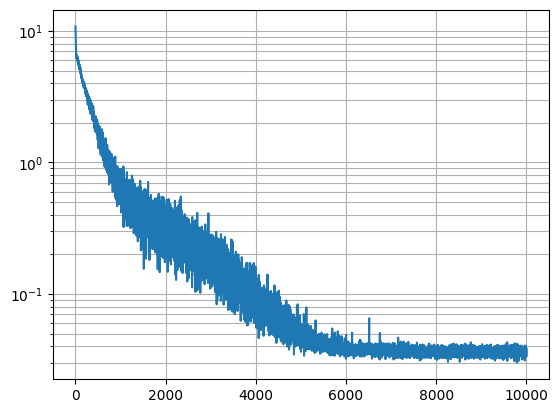

In [5]:
dataloader = gen_batch(cfg.batch_size, cfg.length)
progbar = tqdm.notebook.trange(cfg.decay_steps, mininterval=1)
losses = []
try:
    for step, batch in zip(progbar, dataloader):
        loss = train_step(parallel_model, optimizer, batch)
        progbar.set_postfix(loss=loss.item(), refresh=False)
        losses.append(loss.item())
finally:
    plt.semilogy(losses)
    plt.grid(True, which="both")

In [17]:
rng = nnx.Rngs(0)
temperature = 0.5
prompt = "ROMEO."
prompt_tokens = tokenizer(prompt, return_tensors="jax").input_ids
logits, state = prefill(parallel_model, prompt_tokens)
sequential_model = to_sequential(parallel_model)
token = jax.random.categorical(rng(), logits / temperature)
streamer = TextStreamer(tokenizer, skip_special_tokens=True)
streamer.put(prompt_tokens)
streamer.put(token)
for step in range(512):
    token, state = sample(sequential_model, token, state, temperature=temperature, rng=rng())
    streamer.put(token)
streamer.end()

ROMEO.
A torch for me: let wantons, light of heart,
Tickle the senseless rushes with their heels;
For I am proverb’d with a grandsire phrase,
I’ll be a candle-holder and look on,
The game was ne’er so fair, and I am done.

MERCUTIO.
Tut, dun’s the mouse, the constable’s own word:
If thou art dun, we’ll draw thee from the mire
Or save your reverence love, wherein thou stickest
Up to the ears. Come, we burn daylight, ho.

ROMEO.
Nay, that’s not so.

MERCUTIO.
I mean sir, in delay
We waste our lights in vain, light lights by day.
Take our good meaning, for our judgment sits
Five times in that ere once in our five wits.

ROMEO.
And we mean well in going to this mask;
But ’tis no wit to go.

MERCUTIO.
Why, may one ask?

ROMEO.
I dreamt a dream tonight.

MERCUTIO.
And so did I.

ROMEO.
Well what was yours?

MERCUTIO.
That dreamers often lie.

ROMEO.
In bed asleep, while they do dream things true.

MERCUTIO.
O, then, I see Queen Mab hath been with you.
She is the fairies’ midwife, and she com